In [90]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import struct
from types import SimpleNamespace
import const
from scipy.special import erf

from pp_mpi import *


In [2]:
sim_list = ['rho14', 'fiducial', 'rho16', 'rho17']
label_list = [r'$\rho = 10^{-14}~{\rm g/cm^3}$', r'$\rho = 10^{-15}~{\rm g/cm^3}$', r'$\rho = 10^{-16}~{\rm g/cm^3}$', r'$\rho = 10^{-17}~{\rm g/cm^3}$']
nsim = len(sim_list)


In [107]:
def calc_conf(data, sig=1):
    
    frac = erf(1/np.sqrt(2))/2
    data = np.sort(data)
    mean = np.mean(data)
    argmean = np.argmin(np.abs(data - mean))
    llim = data[argmean - int(data.size*frac)]
    ulim = data[argmean + int(data.size*frac)]
    
    return mean, llim, ulim


In [3]:
data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    data = ener_loss_mech(data_path, chunk_size=512, chunk_num=2**12)
    data_list.append(data)


AttributeError: Can't pickle local object 'get_func_alldata.<locals>.func_alldata'

(0.0, 100.0)

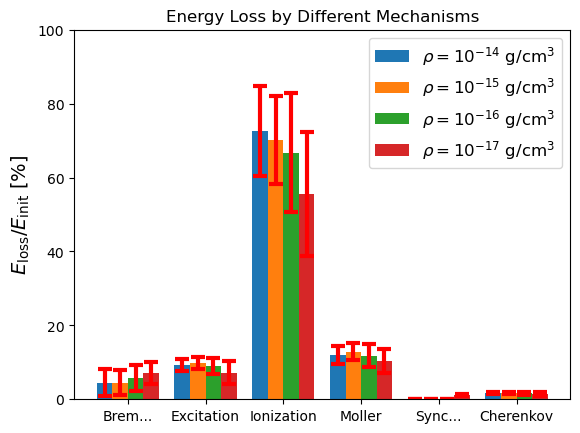

In [32]:
fig, ax = plt.subplots()

ener_init = 1e6
width = 1/(nsim+1)

for i, data in enumerate(data_list):
    
    ener_loss_avg = np.mean(data, axis=0)
    ener_loss_std = np.std(data, axis=0)
    
    offset = (i-1.5)*width
    ax.bar(np.arange(6)+offset, 100*ener_loss_avg/ener_init, width=width, label=label_list[i])
    ax.errorbar(np.arange(6)+offset, 100*ener_loss_avg/ener_init, yerr=100*ener_loss_std/ener_init, color='red', zorder=1, linestyle='', capsize=5, elinewidth=3, capthick=3)

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['Brem...', 'Excitation', 'Ionization', 'Moller', 'Sync...', 'Cherenkov'])
ax.set_ylabel(r'$E_{\rm loss} / E_{\rm init}$ [$\%$]', fontsize=14)
ax.set_title('Energy Loss by Different Mechanisms')
ax.legend(fontsize=12)
ax.set_ylim(0, 100)

#save_fig('ener_mech')


In [37]:
tmax = 2*const.day
num = 128
time_bins = np.linspace(0, tmax, num)
time = (time_bins[:-1] + time_bins[1:]) / 2

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = ener_time(data_path, chunk_size=512, chunk_num=2**15, time_bins=time_bins)
    data_list.append(data)


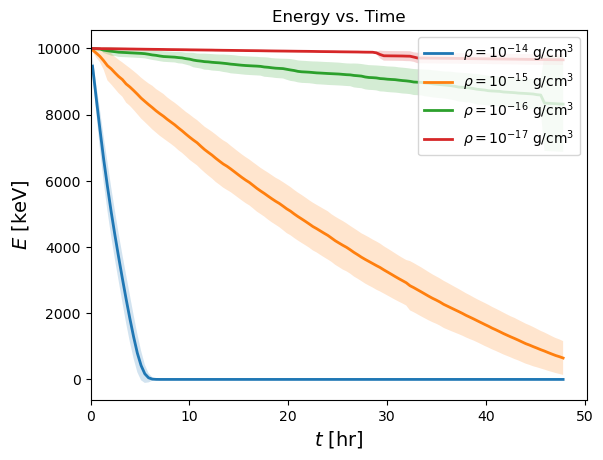

In [40]:
fig, ax = plt.subplots()

for i, data in enumerate(data_list):

    ener = data[:, 1, :] / np.maximum(data[:, 0, :], np.ones_like(data[:, 0, :]))
    ener_avg = np.mean(ener, axis=0)
    ener_std = np.std(ener, axis=0)
    
    ax.plot(time/const.hr, ener_avg/1e3, lw=2, label=label_list[i])
    ax.fill_between(time/const.hr, (ener_avg-ener_std)/1e3, (ener_avg+ener_std)/1e3, lw=2, alpha=0.2)

ax.set_xlabel(r'$t$ $[{\rm hr}]$', fontsize=14)
ax.set_ylabel(r'$E$ $[{\rm keV}]$', fontsize=14)
ax.set_title('Energy vs. Time')
ax.set_xlim(0)
ax.legend(loc=1)

#save_fig('ener_time')


In [127]:
time_bins = np.arange(9) * const.hr
time = (time_bins[:-1] + time_bins[1:]) / 2

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = ener_time(data_path, chunk_size=2048, chunk_num=2**14, time_bins=time_bins)
    data_list.append(data)


Saved figure as 'spec_evolution-062820241140.png'


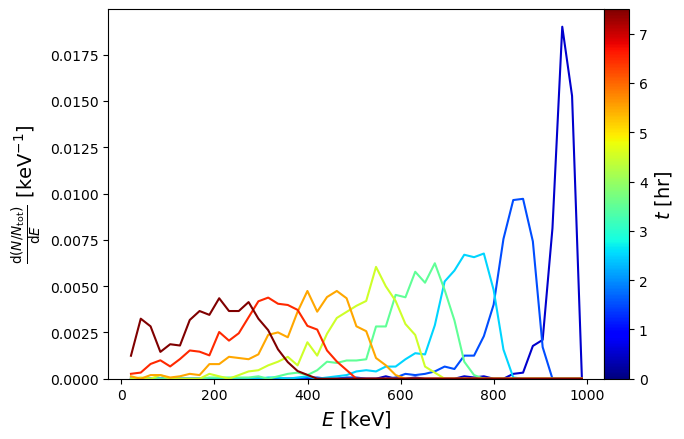

In [133]:
fig, ax = plt.subplots()

data = data_list[0]
data_ener = data[:, 1, :] / np.maximum(data[:, 0, :], np.ones_like(data[:, 0, :]))

ener_bins = np.linspace(10000, 1e6, 48)
dener = ener_bins[1:] - ener_bins[:-1]
ener = (ener_bins[:-1] + ener_bins[1:]) / 2

norm = Normalize(0/const.hr, time[-1]/const.hr)
color_list = mpl.colormaps['jet'](norm(time/const.hr))

for i in range(len(time)):
    num_bin, _ = np.histogram(data_ener[:, i], bins=ener_bins)
    ax.plot(ener/1e3, num_bin/np.sum(num_bin)/dener/(1/1e3), color=color_list[i])
    
ax.set_ylim(0)    
ax.set_xlabel(r'$E$ [${\rm keV}$]', fontsize=14)
ax.set_ylabel(r'$\frac{{\rm d}(N/N_{\rm tot})}{{\rm d}E}$ [${\rm keV^{-1}}$]', fontsize=14)

sm = ScalarMappable(norm, cmap='jet')
cax = ax.inset_axes([1, 0, 0.05, 1])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$t$ [${\rm hr}$]', fontsize=14)
    
save_fig('spec_evolution')
    

(0.0, 0.0025180639144053735)

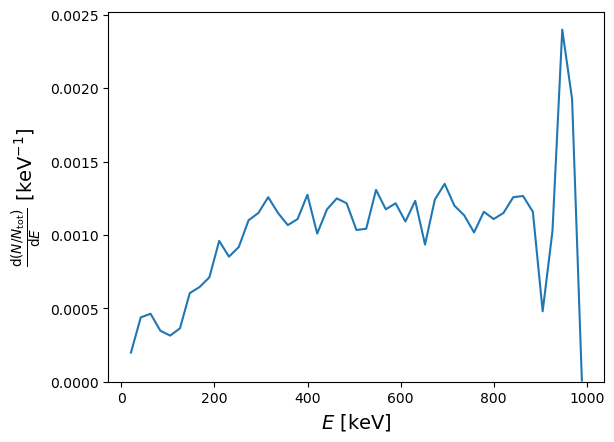

In [134]:
fig, ax = plt.subplots()

num_bin, _ = np.histogram(data_ener[data_ener>0], bins=ener_bins)
ax.plot(ener/1e3, num_bin/np.sum(num_bin)/dener/(1/1e3))
   
ax.set_xlabel(r'$E$ [${\rm keV}$]', fontsize=14)
ax.set_ylabel(r'$\frac{{\rm d}(N/N_{\rm tot})}{{\rm d}E}$ [${\rm keV^{-1}}$]', fontsize=14)
ax.set_ylim(0)

# save_fig('spec_total')


In [64]:
Zelem_bins = np.arange(0.5, 99.5)
Zelem = (Zelem_bins[1:] + Zelem_bins[:-1]) / 2

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = num_ion(data_path, chunk_size=512, chunk_num=2**12, Zelem_bins=Zelem_bins)
    data_list.append(data)


Text(0.5, 1.05, 'Number of Ionizations per Element')

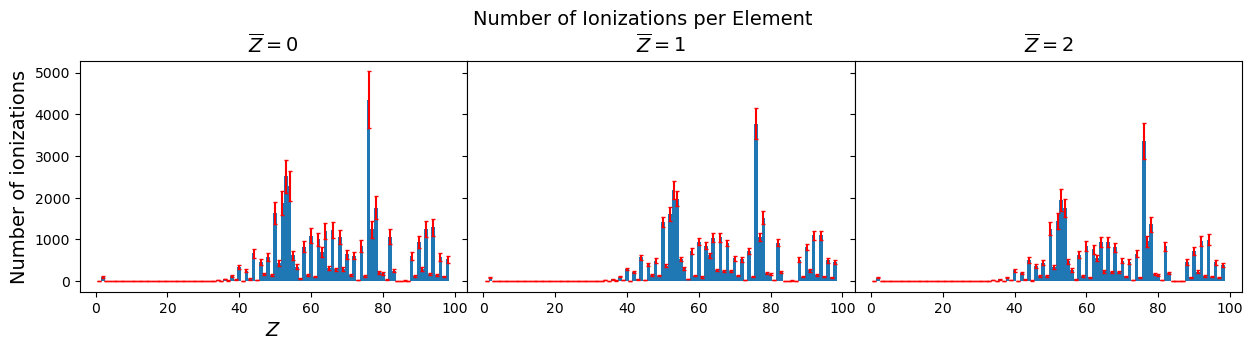

In [68]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 3))
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

for i, data in enumerate(data_list):
    
    nion_avg = np.mean(data, axis=0)
    nion_std = np.std(data, axis=0)
    
    axs[i].bar(Zelem, nion_avg, width=1)
    axs[i].errorbar(Zelem, nion_avg, yerr=nion_std, color='red', zorder=1, linestyle='', capsize=1.5)
    axs[i].set_title(label_list[i], fontsize=14)

axs[0].set_xlabel(r'$Z$', fontsize=14)
axs[0].set_ylabel(r'Number of ionizations', fontsize=14)
plt.suptitle('Number of Ionizations per Element', fontsize=14, y=1.05)

#save_fig('nion')


In [71]:
num = 64
ener_bins = np.logspace(-1, 5, num)
ener = (ener_bins[1:] + ener_bins[:-1]) / 2
id_list, data = num_sec('../../scratch/ion2/data', chunk_size=128, chunk_num=2**12, ener_bins=ener_bins)


Text(0.5, 1.0, 'Spectrum of Secondary Electrons Produced by Ionization')

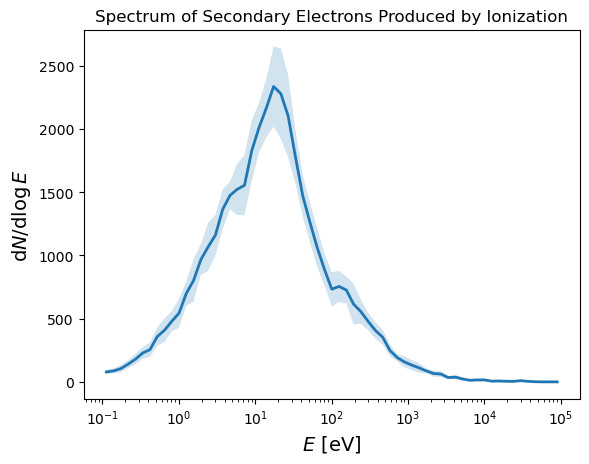

In [72]:
fig, ax = plt.subplots()

nsec_avg = np.mean(data, axis=0)
nsec_std = np.std(data, axis=0)
dlogE = np.log10(ener_bins)[1:] - np.log10(ener_bins)[:-1]

ax.plot(ener, nsec_avg/dlogE, lw=2)
ax.fill_between(ener, (nsec_avg-nsec_std)/dlogE, (nsec_avg+nsec_std)/dlogE, lw=2, alpha=0.2)
ax.set_xscale('log')

ax.set_xlabel(r'$E$ $[{\rm eV}]$', fontsize=14)
ax.set_ylabel(r'${\rm d}N/{\rm d}\log E$', fontsize=14)
ax.set_title('Spectrum of Secondary Electrons Produced by Ionization')

#save_fig('spec_ion')
    

In [74]:
tmax = 40000
num = 128
time_bins = np.linspace(0, tmax, num)
time = (time_bins[:-1] + time_bins[1:]) / 2

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = ener_loss_time(data_path, chunk_size=512, chunk_num=2**14, time_bins=time_bins)
    data_list.append(data)


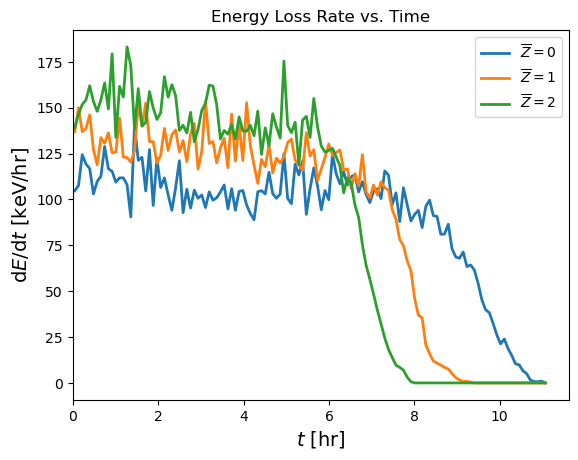

In [79]:
fig, ax = plt.subplots()

for i, data in enumerate(data_list):

    ener_loss_avg = np.mean(data, axis=0)
    ener_loss_std = np.std(data, axis=0)
    dt = time_bins[1:] - time_bins[:-1]
    
    ax.plot(time/const.hr, ener_loss_avg/dt/(1e3/const.hr), lw=2, label=label_list[i])

ax.set_xlabel(r'$t$ $[{\rm hr}]$', fontsize=14)
ax.set_ylabel(r'${\rm d}E/{\rm d}t$ $[{\rm keV/hr}]$', fontsize=14)
ax.set_title('Energy Loss Rate vs. Time')
ax.set_xlim(0)
ax.legend(loc=1)

#save_fig('ener_time')


In [ ]:
num = 64
dis_bins = np.logspace(np.log10(0.01*const.AU), np.log10(10*const.AU), num)
dis = (dis_bins[1:] + dis_bins[:-1]) / 2

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = ener_loss_dis(data_path, chunk_size=512, chunk_num=2**14, dis_bins=dis_bins)
    data_list.append(data)


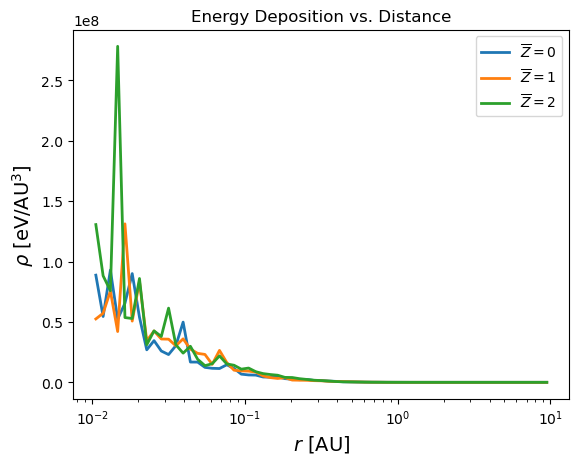

In [84]:
fig, ax = plt.subplots()

for i in range(nsim):
    
    ener_loss_avg = np.mean(data_list[i], axis=0)
    dV = (dis_bins[1:] - dis_bins[:-1]) * 4*np.pi*dis**2
    
    ax.plot(dis/const.AU, ener_loss_avg/dV/(1/const.AU**3), lw=2, label=label_list[i])

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r"$r$ [${\rm AU}$]", fontsize=14)
ax.set_ylabel(r"$\rho$ [${\rm eV/AU^3}$]", fontsize=14)
ax.set_title('Energy Deposition vs. Distance')
ax.legend()

#save_fig('ener_dis')


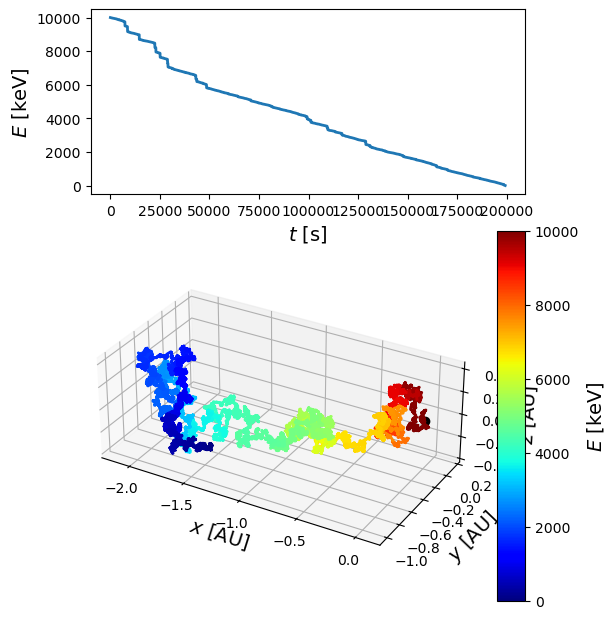

In [62]:
data = read_1part('../../scratch/weakBco/data', chunk_size=128)

plot_traj(data, var_c=data.ener, unit_c=1e3, cbar_label=r'$E$ [${\rm keV}$]', cval=10000000, do_top=True)
#plt.suptitle(r'$B=0~{\rm G}$', fontsize=14, y=1.4, x=0.55)

#save_fig('traj_noB')
